In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, SelectKBest, f_classif, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy import stats
from sklearn.externals import joblib

In [3]:
from reskit.core import Pipeliner

In [4]:
conn = pd.read_csv("RESULTS_C_D_E_DE_KONDRATEVA_10.12.csv")
thickness_lh = pd.read_csv("mri_features/th_lh_last.csv", index_col=0)
thickness_rh = pd.read_csv("mri_features/th_rh_last.csv", index_col=0)
thickness = thickness_lh.join(thickness_rh, lsuffix="_lh", rsuffix="_rh")
volumes = pd.read_csv("mri_features/vol_last.csv", index_col=0)
info = pd.read_csv("таблица_10102017.csv", index_col=0, header=1)

target = conn.target
D_target = np.int8(np.logical_or(target == "D", target == "DE"))
E_target = np.int8(np.logical_or(target == "E", target == "DE"))
# 4 classes (С(0), D(1), E(2), DE(3))
DE_target = D_target + E_target * 2

idx = np.argsort(thickness.index)
thickness = thickness.iloc[idx].drop(["target_lh", "target_rh"], axis=1).reset_index(drop=True)
volumes = volumes.iloc[idx].reset_index(drop=True)

mri_data = thickness.join(volumes)
# conn.drop(["index", "target"], axis=1, inplace=True)
# info.reset_index(drop=True, inplace=True)
# info["пол (1-мужской, 2- женский)"] -= 1
# all_data = thickness.join(volumes).join(conn)
# all_data_nan = pd.DataFrame(all_data.loc[:, all_data.isnull().any(axis=0)].isnull(), dtype=int)
# all_data = all_data.join(all_data_nan, rsuffix="_nan")

In [5]:
mri_data.head()

,bankssts_NumVert_lh,caudalanteriorcingulate_NumVert_lh,caudalmiddlefrontal_NumVert_lh,cuneus_NumVert_lh,entorhinal_NumVert_lh,fusiform_NumVert_lh,inferiorparietal_NumVert_lh,inferiortemporal_NumVert_lh,isthmuscingulate_NumVert_lh,lateraloccipital_NumVert_lh,...,Right-WM-hypointensities_normRange,non-WM-hypointensities_normRange,Left-non-WM-hypointensities_normRange,Right-non-WM-hypointensities_normRange,Optic-Chiasm_normRange,CC_Posterior_normRange,CC_Mid_Posterior_normRange,CC_Central_normRange,CC_Mid_Anterior_normRange,CC_Anterior_normRange
0,1794,1030,3395,2525,660,6353,7740,5702,1631,9444,...,0.0,0.0,0.0,0.0,86.0,79.0,105.0,77.0,73.0,84.0
1,1893,1117,4504,2560,845,5522,10129,7056,1707,9203,...,0.0,0.0,0.0,0.0,94.0,78.0,108.0,97.0,90.0,92.0
2,1089,900,2295,2624,666,4210,6247,5159,1575,7472,...,0.0,0.0,0.0,0.0,83.0,94.0,95.0,97.0,81.0,129.0
3,1624,1755,3126,2859,614,4284,6865,4909,1688,9196,...,0.0,0.0,0.0,0.0,90.0,79.0,96.0,94.0,119.0,117.0
4,1377,1186,4497,3258,503,5292,7041,6269,1647,9720,...,0.0,0.0,0.0,0.0,110.0,71.0,76.0,85.0,77.0,111.0


In [6]:
# отбор признаков на основе модели
# аналогично SelectFromModel, но на основе количества признаков, а не порога

from sklearn.base import BaseEstimator, MetaEstimatorMixin, clone
from sklearn.feature_selection.base import SelectorMixin
from sklearn.feature_selection.from_model import _get_feature_importances
from sklearn.utils.metaestimators import if_delegate_has_method

class SelectNFeaturesFromModel(BaseEstimator, SelectorMixin, MetaEstimatorMixin):
    def __init__(self, estimator, n_selected, prefit=False):
        self.estimator = estimator
        self.n_selected = n_selected
        self.prefit = prefit

    def _get_support_mask(self):
        if self.prefit:
            estimator = self.estimator
        elif hasattr(self, 'estimator_'):
            estimator = self.estimator_
        else:
            raise ValueError(
                'Either fit SelectFromModel before transform or set "prefit='
                'True" and pass a fitted estimator to the constructor.')
        scores = _get_feature_importances(estimator)
        threshold = np.sort(scores)[-self.n_selected]
        return scores >= threshold

    def fit(self, X, y=None, **fit_params):
        if self.prefit:
            raise NotFittedError(
                "Since 'prefit=True', call transform directly")
        self.estimator_ = clone(self.estimator)
        self.estimator_.fit(X, y, **fit_params)
        return self

    @property
    def threshold_(self):
        scores = _get_feature_importances(self.estimator_, self.norm_order)
        return np.sort(scores)[-n_selected]
    
    @if_delegate_has_method('estimator')
    def partial_fit(self, X, y=None, **fit_params):
        if self.prefit:
            raise NotFittedError(
                "Since 'prefit=True', call transform directly")
        if not hasattr(self, "estimator_"):
            self.estimator_ = clone(self.estimator)
        self.estimator_.partial_fit(X, y, **fit_params)
        return self

In [7]:
n_features = [10 * 2 ** i for i in range(5)]
n_components = [2 ** i for i in range(5)]
dim_reduction_methods = []
dim_reduction_methods += [SelectKBest(stats.ttest_ind, n) for n in n_features]
dim_reduction_methods += [SelectKBest(f_classif, n) for n in n_features]
dim_reduction_methods += [SelectNFeaturesFromModel(RandomForestClassifier(n_estimators=100, random_state=42), n) for n in n_features]
# dim_reduction_methods += [SelectNFeaturesFromModel(LogisticRegression(), n) for n in n_features]
# dim_reduction_methods += [PCA(n) for n in n_components]
# dim_reduction_methods += [LocallyLinearEmbedding(n_components=n, random_state=42) for n in n_components]

In [8]:
def get_svc_grid(cv, dim_reduction_methods,
                 svc_kernel_l=None, svc_c_l=None, svc_gamma_l=None):

    pipe = Pipeline([
        ("Fill_Median", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
        ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', SVC(random_state=42)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if svc_kernel_l is not None:
        param_grid['classifier__kernel'] = svc_kernel_l
    if svc_c_l is not None:
        param_grid['classifier__C'] = svc_c_l
    if svc_gamma_l is not None:
        param_grid['classifier__gamma'] = svc_gamma_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=cv)

In [9]:
def get_lr_grid(cv, dim_reduction_methods,
                 lr_c_l=None):
    
    pipe = Pipeline([
        ("Fill_Median", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
        ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', LogisticRegression(random_state=42)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if lr_c_l is not None:
        param_grid['classifier__C'] = lr_c_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=cv)

In [10]:
def get_rfc_grid(cv, dim_reduction_methods,
                 rfc_n_estimators_l=None):
    
    pipe = Pipeline([
        ("Fill_Median", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
        ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', RandomForestClassifier(random_state=42)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if rfc_n_estimators_l is not None:
        param_grid['classifier__n_estimators'] = rfc_n_estimators_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=cv)

In [11]:
def get_knn_grid(cv, dim_reduction_methods,
                 knn_n_neighbors_l=None, knn_weights_l=None, knn_p_l=None):
    
    pipe = Pipeline([
        ("Fill_Median", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
        ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', KNeighborsClassifier()),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if knn_n_neighbors_l is not None:
        param_grid['classifier__n_neighbors'] = knn_n_neighbors_l
    if knn_weights_l is not None:
        param_grid['classifier__weights'] = knn_weights_l
    if knn_p_l is not None:
        param_grid['classifier__p'] = knn_p_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=cv)

In [47]:
# set printoptions
pd.set_option('expand_frame_repr', True)
pd.set_option('max_colwidth', 150)

In [48]:
def print_results(clf_grid_dict):
    results = {
            "classifier" : [], 
            "best parameters" : [],
            "best dim. reduction method" : [],
            "mean" : [],
            "std" : []
           }
    
    for clf, grid in clf_grid_dict.items():
        results["classifier"].append(clf)
        results["best parameters"].append(", ".join(
            [param + " = " + str(best_value) for param, best_value in grid.best_params_.items() if param != 'dim_reduction']))
        results["best dim. reduction method"].append(grid.best_params_['dim_reduction'])
        idx = grid.best_index_
        results["mean"].append(grid.cv_results_['mean_test_score'][idx])
        results["std"].append(grid.cv_results_['std_test_score'][idx])
        
    results = pd.DataFrame(results, columns=["classifier", "best parameters", "best dim. reduction method", "mean", "std"])
    display(results.set_index("classifier"))
    
    # draw graph
    width = 0.9
    for i in results.index:
        plt.bar(i, results.loc[i, "mean"], width, yerr=results.loc[i, "std"], label=results.loc[i, "classifier"])
    plt.xticks(range(results.shape[0]), results.loc[:, "classifier"])
    plt.axis(ymin=0.0, ymax=1.0)
    plt.show()
    
    print("Best model: ")
    clf = results.loc[results["mean"].argmax(), "classifier"]
    print(clf)
    print("\n".join(
            [param + " = " + str(best_value) for param, best_value in clf_grid_dict[clf].best_params_.items()]))
    print()
    print("mean =", results["mean"].max())
    print("std =", results.loc[results["mean"].argmax(), "std"])

,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__kernel = rbf, classifier__gamma = 0.0001, classifier__C = 100","PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,\n svd_solver='auto', tol=0.0, whiten=False)",0.393333,0.089194
LR,classifier__C = 1e-06,"SelectKBest(k=100, score_func=<function ttest_ind at 0x7fcb0a39b7b8>)",0.358333,0.089520
KNN,"classifier__n_neighbors = 15, classifier__weights = distance, classifier__p = 1","SelectKBest(k=100, score_func=<function ttest_ind at 0x7fcb0a39b7b8>)",0.358333,0.101721
RFC,classifier__n_estimators = 900,"SelectKBest(k=100, score_func=<function ttest_ind at 0x7fcb0a39b7b8>)",0.410000,0.077889


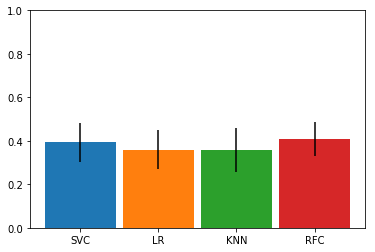

Best model: 
RFC
classifier__n_estimators = 900
dim_reduction = SelectKBest(k=100, score_func=<function ttest_ind at 0x7fcb0a39b7b8>)

mean = 0.41
std = 0.077888809637


In [49]:
print_results({
    "SVC" : grid_cv_svc,
    "LR" : grid_cv_lr,
    "RFC" : grid_cv_rfc,
    "KNN" : grid_cv_knn
              })  

In [50]:
def train_grid_cv(X, y, n_splits):
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=30 // n_splits, random_state=42)
    
    n_features = [5, 10, 20, 50, 100]
#     n_features = [5 * 2 ** i for i in range(5)]
    n_components = [1, 2, 3, 5, 10, 15, 20]
#     n_components = [2 ** i for i in range(5)]
    
    # list of dimensionality reduction methods
    dim_reduction_methods = []
    dim_reduction_methods += [SelectKBest(stats.ttest_ind, n) for n in n_features]
    dim_reduction_methods += [SelectKBest(f_classif, n) for n in n_features]
    dim_reduction_methods += [SelectNFeaturesFromModel(RandomForestClassifier(n_estimators=100, random_state=42), n) for n in n_features]
#     dim_reduction_methods += [SelectNFeaturesFromModel(LogisticRegression(), n) for n in n_features]
    dim_reduction_methods += [PCA(n) for n in n_components]
#     dim_reduction_methods += [LocallyLinearEmbedding(n_components=n, random_state=42) for n in n_components]
    
    print("Training SVC...")
    grid_cv_svc = get_svc_grid(cv, dim_reduction_methods, 
                               svc_kernel_l=["rbf", "linear"],
                               svc_c_l=[10 ** i for i in range(-6, 4, 2)],
                               svc_gamma_l=[10 ** i for i in range(-6, 2, 2)])
    start_time = time.time()
    grid_cv_svc.fit(X, y)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print("Training LR...")
    grid_cv_lr = get_lr_grid(cv, dim_reduction_methods, 
                             lr_c_l=[10 ** i for i in range(-6, 2, 2)])
    start_time = time.time()
    grid_cv_lr.fit(X, y)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print("Training RFC...")
    grid_cv_rfc = get_rfc_grid(cv, dim_reduction_methods, 
                               rfc_n_estimators_l=[i for i in range(300, 950, 150)])
    start_time = time.time()
    grid_cv_rfc.fit(X, y)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print("Training KNN...")
    class_size_tr = sum([y == 0]) - 5
    grid_cv_knn = get_knn_grid(cv, dim_reduction_methods, 
                              knn_p_l=[1, 2],
                              knn_weights_l=["uniform", "distance"],
                              knn_n_neighbors_l=[i for i in range(5, class_size_tr - 1, 2)])
    start_time = time.time()
    grid_cv_knn.fit(X, y)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print_results({
        "SVC" : grid_cv_svc,
        "LR" : grid_cv_lr,
        "RFC" : grid_cv_rfc,
        "KNN" : grid_cv_knn
                  })        
    
    return grid_cv_svc, grid_cv_lr, grid_cv_rfc, grid_cv_knn

### Подбор интервалов для значений гиперпараметров
Классификаторы с различными значениями гиперпараметров обучаются по всей выборке, но не для того, чтобы выбрать оптимальное значение, а для того, чтобы определить общую тендецию изменения качества при варьировании этого параметра и приблизительный интервал, по которому имеет смысл выполнять GridSearch.

Классификаторы обучаются на небольшом количестве признаков (50), т.к. перед обучением модели в GridSearch также выполняется снижение размерности. 

* #### ориентировочная зависимость accuracy SVC("rbf") от gamma

100%|██████████| 40/40 [02:05<00:00,  3.14s/it]


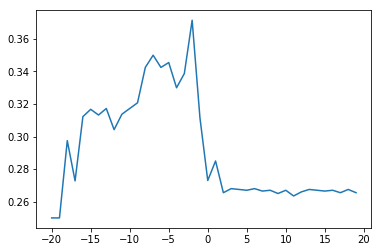

In [19]:
X, y = mri_data, DE_target
range_l = np.arange(-20, 20)
gamma_l = [10. ** i for i in range_l]
scores = []
for gamma in tqdm(gamma_l):
    pipe = Pipeline([
    ('FillMedian', Imputer(strategy="median")),
    ('StdScaler', StandardScaler()),
    ("VarTh", VarianceThreshold()),
    ('dim_reduction', SelectKBest(stats.ttest_ind, k=50)),
    ('SVC', SVC(gamma=gamma, kernel="rbf"))
                     ])
    scores.append(np.mean(cross_val_score(pipe, X, y, scoring="accuracy", cv=RepeatedStratifiedKFold(n_repeats=40, n_splits=5))))
plt.plot(range_l, scores)

* #### ориентировочная зависимость accuracy SVC("rbf", gamma=1e-5) от C

100%|██████████| 40/40 [02:10<00:00,  3.26s/it]


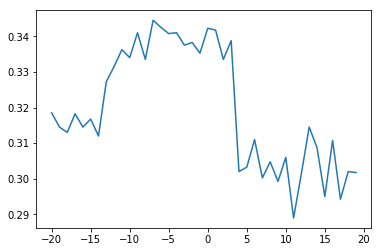

In [20]:
X, y = mri_data, DE_target
range_l = np.arange(-20, 20)
C_l = [10. ** i for i in range_l]
scores = []
for C in tqdm(C_l):
    pipe = Pipeline([
    ('FillMedian', Imputer(strategy="median")),
    ('StdScaler', StandardScaler()),
    ("VarTh", VarianceThreshold()),
    ('dim_reduction', SelectKBest(stats.ttest_ind, k=50)),
    ('SVC', SVC(C=C, gamma=1e-5, kernel="rbf"))
                     ])
    scores.append(np.mean(cross_val_score(pipe, X, y, scoring="accuracy", cv=RepeatedStratifiedKFold(n_repeats=40, n_splits=5))))
plt.plot(range_l, scores)

* #### ориентировочная зависимость accuracy SVC("linear", gamma=1e-5) от C

100%|██████████| 40/40 [02:11<00:00,  3.28s/it]


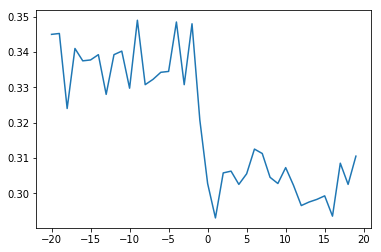

In [30]:
X, y = mri_data, DE_target
range_l = np.arange(-20, 20)
C_l = [10. ** i for i in range_l]
scores = []
for C in tqdm(C_l):
    pipe = Pipeline([
    ('FillMedian', Imputer(strategy="median")),
    ('StdScaler', StandardScaler()),
    ("VarTh", VarianceThreshold()),
    ('dim_reduction', SelectKBest(stats.ttest_ind, k=50)),
    ('SVC', SVC(C=C, kernel="linear"))
                     ])
    scores.append(np.mean(cross_val_score(pipe, X, y, scoring="accuracy", cv=RepeatedStratifiedKFold(n_repeats=40, n_splits=5))))
plt.plot(range_l, scores)

* #### ориентировочная зависимость accuracy LR от C

100%|██████████| 40/40 [02:42<00:00,  4.06s/it]


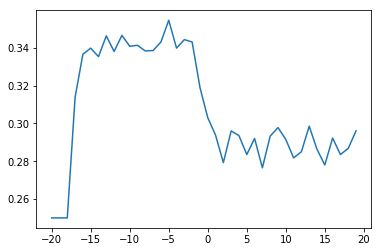

In [14]:
X, y = mri_data, DE_target
range_l = np.arange(-20, 20)
C_l = [10. ** i for i in range_l]
scores = []
for C in tqdm(C_l):
    pipe = Pipeline([
    ('FillMedian', Imputer(strategy="median")),
    ('StdScaler', StandardScaler()),
    ("VarTh", VarianceThreshold()),
    ('dim_reduction', SelectKBest(stats.ttest_ind, k=50)),
    ('LR', LogisticRegression(C=C))
                     ])
    scores.append(np.mean(cross_val_score(pipe, X, y, scoring="accuracy", cv=RepeatedStratifiedKFold(n_repeats=40, n_splits=5))))
plt.plot(range_l, scores)

* #### ориентировочная зависимость accuracy RFC от n_estimators

100%|██████████| 20/20 [54:10<00:00, 162.52s/it]


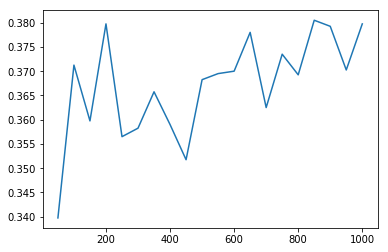

In [14]:
X, y = mri_data, DE_target
range_l = np.arange(50, 1050, 50)
n_estimators_l = [i for i in range_l]
scores = []
for n_estimators in tqdm(n_estimators_l):
    pipe = Pipeline([
    ('FillMedian', Imputer(strategy="median")),
    ('StdScaler', StandardScaler()),
    ("VarTh", VarianceThreshold()),
    ('dim_reduction', SelectKBest(stats.ttest_ind, k=50)),
    ('RFC', RandomForestClassifier(n_estimators=n_estimators))
                     ])
    scores.append(np.mean(cross_val_score(pipe, X, y, scoring="accuracy", cv=RepeatedStratifiedKFold(n_repeats=40, n_splits=5))))
plt.plot(range_l, scores)

* #### ориентировочная зависимость accuracy KNN(weights="distance", p=2) от n_neighbors

100%|██████████| 20/20 [01:07<00:00,  3.40s/it]


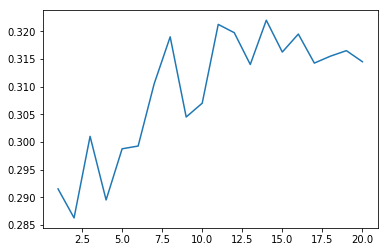

In [29]:
X, y = mri_data, DE_target
range_l = np.arange(1, 21)
n_neighbors_l = [i for i in range_l]
scores = []
for n_neighbors in tqdm(n_neighbors_l):
    pipe = Pipeline([
    ('FillMedian', Imputer(strategy="median")),
    ('StdScaler', StandardScaler()),
    ("VarTh", VarianceThreshold()),
    ('dim_reduction', SelectKBest(stats.ttest_ind, k=50)),
    ('KNN', KNeighborsClassifier(n_neighbors=n_neighbors, weights="distance"))
                     ])
    scores.append(np.mean(cross_val_score(pipe, X, y, scoring="accuracy", cv=RepeatedStratifiedKFold(n_repeats=40, n_splits=5))))
plt.plot(range_l, scores)

* #### ориентировочная зависимость accuracy KNN(weights="distance", p=1) от n_neighbors

100%|██████████| 20/20 [01:09<00:00,  3.48s/it]


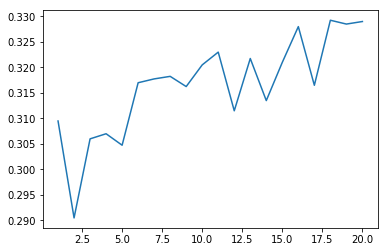

In [28]:
X, y = mri_data, DE_target
range_l = np.arange(1, 21)
n_neighbors_l = [i for i in range_l]
scores = []
for n_neighbors in tqdm(n_neighbors_l):
    pipe = Pipeline([
    ('FillMedian', Imputer(strategy="median")),
    ('StdScaler', StandardScaler()),
    ("VarTh", VarianceThreshold()),
    ('dim_reduction', SelectKBest(stats.ttest_ind, k=50)),
    ('KNN', KNeighborsClassifier(n_neighbors=n_neighbors, weights="distance", p=1))
                     ])
    scores.append(np.mean(cross_val_score(pipe, X, y, scoring="accuracy", cv=RepeatedStratifiedKFold(n_repeats=40, n_splits=5))))
plt.plot(range_l, scores)

### Training

Training SVC...
(training took 4257.199155092239s)

Training LR...
(training took 211.05649518966675s)

Training RFC...
(training took 3929.5113706588745s)

Training KNN...
(training took 1653.4171245098114s)



,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__kernel = rbf, classifier__gamma = 0.01, classifier__C = 1","SelectKBest(k=50, score_func=<function ttest_ind at 0x7fcb0a39b7b8>)",0.391667,0.090446
LR,classifier__C = 1e-06,"SelectKBest(k=100, score_func=<function ttest_ind at 0x7fcb0a39b7b8>)",0.358333,0.089520
KNN,"classifier__n_neighbors = 15, classifier__weights = distance, classifier__p = 1","SelectKBest(k=100, score_func=<function ttest_ind at 0x7fcb0a39b7b8>)",0.358333,0.101721
RFC,classifier__n_estimators = 900,"SelectKBest(k=100, score_func=<function ttest_ind at 0x7fcb0a39b7b8>)",0.410000,0.077889


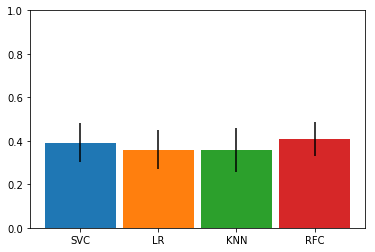

Best model: 
RFC
classifier__n_estimators = 900
dim_reduction = SelectKBest(k=100, score_func=<function ttest_ind at 0x7fcb0a39b7b8>)

mean = 0.41
std = 0.077888809637


In [51]:
X, y = mri_data, DE_target
grid_cv_svc, grid_cv_lr, grid_cv_rfc, grid_cv_knn = train_grid_cv(X, y, n_splits=5)

In [52]:
# save
joblib.dump(grid_cv_svc, 'svc_mri_data_DE.pkl')
joblib.dump(grid_cv_lr, 'lr_mri_data_DE.pkl')
joblib.dump(grid_cv_rfc, 'rfc_mri_data_DE.pkl')
joblib.dump(grid_cv_knn, 'knn_mri_data_DE.pkl')
# load
# grid_cv_svc_DE = joblib.load('svc_mri_data_DE.pkl')
# grid_cv_lr_DE = joblib.load('lr_mri_data_DE.pkl')
# grid_cv_rfc_DE = joblib.load('rfc_mri_data_DE.pkl')
# grid_cv_knn_DE = joblib.load('knn_mri_data_DE.pkl')

['knn_mri_data_DE.pkl']